In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt



In [101]:
class Kalman1D:

    def __init__(self, initial_state, uncertainty, q=0) -> None:
        self.q = q
        self.x_00 = [initial_state]
        self.p_00 = [uncertainty]

        self.x_10 = [self.x_00[-1]]
        self.p_10 = [self.p_00[-1]]
        self.kgs = []

    def update(self, z, r):

        K = self.p_10[-1] / (self.p_10[-1] + r)
        self.kgs.append(K)

        x_11 = self.x_10[-1] + K * (z - self.x_10[-1])
        p_11 = (1 - K) * self.p_10[-1]

        x_21 = x_11
        p_21 = p_11 + self.q

        self.x_00.append(x_11)
        self.x_10.append(x_21)
        self.p_00.append(p_11)
        self.p_10.append(p_21)


class Alpha:

    def __init__(self, initial, alpha) -> None:
        self.alpha = alpha
        self.state = initial
        self.states = [initial]

    def update(self, measurement):
        self.state = (1-self.alpha) * self.state + self.alpha * measurement
        self.states.append(self.state)


In [ ]:
# building
kal = Kalman1D(60, 225, 0)
zs = [48.54, 47.11, 55.01, 55.15, 49.89, 40.86, 46.72, 50.05, 51.27, 49.95]
for z in zs:
    kal.update(z, 25)

plt.plot(range(len(kal.x_10)-1), kal.x_10[1:], label="est")
plt.plot(range(len(zs)), zs, label="zs")
plt.legend()
plt.show()

In [ ]:
# liquid
kal = Kalman1D(10, 100**2, 0)
zs = [48.54, 47.11, 55.01, 55.15, 49.89, 40.86, 46.72, 50.05, 51.27, 49.95]
for z in zs:
    kal.update(z, 0.1)

plt.plot(range(len(kal.x_10)-1), kal.x_10[1:], label="est")
plt.plot(range(len(zs)), zs, label="zs")
plt.legend()
plt.show()

In [ ]:
import sqlite3
import pandas as pd
import ipywidgets as widgets

con = sqlite3.connect("classification-log.sqlite3")

df_full = pd.read_sql_query("SELECT * FROM classification", con)
df_full["timestamp"] = pd.to_datetime(df_full["timestamp"], infer_datetime_format=True)
df_full["run_start"] = pd.to_datetime(df_full["run_start"], infer_datetime_format=True)

df_full["run_start"].unique()

w = widgets.Select(
    options=df_full["run_start"].unique(),
    description="Select run"
)
w


In [ ]:
df = df_full[df_full["run_start"] == w.value].copy()

kal = Kalman1D(5, 1, 1)
r=df.argmax.var()
zs = df.argmax
for z in zs:
    kal.update(z, r)

fig, ax = plt.subplots(figsize=(20,4))
ax.plot(range(len(kal.x_10)-1), kal.x_00[1:], label="x_00")
ax.plot(range(len(kal.x_10)-1), zs, label="zs")
ax.plot(range(len(kal.x_10)-1), kal.x_10[1:], label="x_10")
ax1 = ax.twinx()
ax1.plot(range(len(kal.x_10)-1), kal.p_00[1:], '--',label="p_est")
ax1.plot(range(len(kal.x_10)-1), kal.p_10[1:], '--',label="p_pred")
ax.legend(loc="lower right")
ax1.legend()
plt.show()

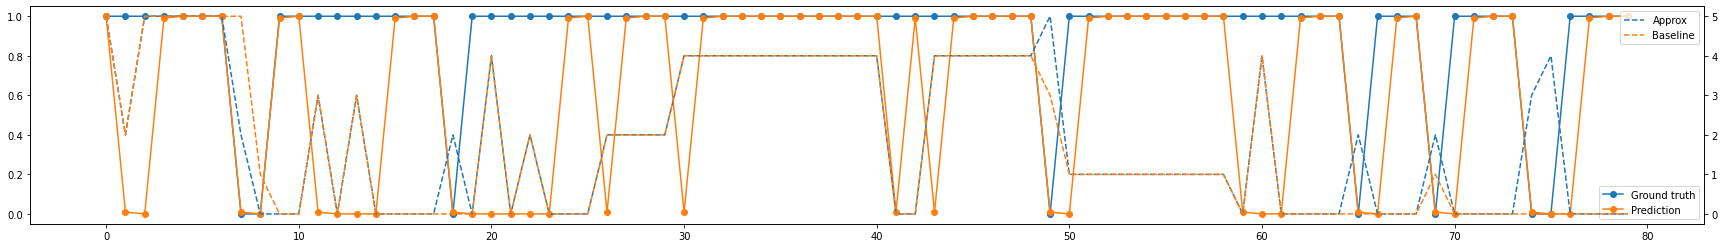

In [122]:
df = df_full[df_full["run_start"] == w.value].copy()
df = df[:80]

zs = (df.argmax[1:].values == df.argmax[:-1].values).astype(int)
zs_true = (df.argmax == df.argmax_baseline).astype(int)

kal = Kalman1D(1, 10, q=10)
r = zs_true.var()
for z in zs:
    kal.update(z, r)


fig, ax = plt.subplots(figsize=(30, 4))
# ax.plot(range(len(kal.x_10)-1), kal.x_00[1:], label="x_00")
ax.plot(range(len(zs_true)), zs_true, 'o-', label="Ground truth")
ax.plot(range(len(kal.x_10)), kal.x_10, 'o-', label="Prediction")
# ax.plot(range(1, len(zs)+1), zs, '.', label="Input")
# ax.plot(range(len(kal.states)), kal.states, 'o-', label="x_10")
ax.legend(loc="lower right")

ax1 = ax.twinx()
ax1.plot(range(len(df.argmax)), df.argmax, '--',label="Approx")
ax1.plot(range(len(df.argmax_baseline)), df.argmax_baseline, '--',label="Baseline")
ax1.legend()

plt.show()


In [ ]:
# 